# ABOUT


Datascientest's Datascientist continuous bootcamp - cohorte Mars2022 -  AeroBOT project

**Tutor**

* Alban THUET

**Authors:**

* Hélène ASSIR
* [Ioannis STASINOPOULOS](https://www.linkedin.com/in/ioannis-stasinopoulos/)

</br>

---
</br>

**Version History**

Version | Date       | Author(s)  | Modification
--------|----------- | ---------  | --------------------------
2.1     | 28/09/2022 | H.A., I.S. | Use df_for_Anomaly_prediction.pkl as data source 
2.0     | 13/09/2022 | H.A., I.S. | Add WordEmbedding 1vsAll code 
1.1     | 29/07/2022 | H.A.       | Compilation of all BOW models 
1.0     | 24/07/2022 | I.S, H.A.  | Document creation

This notebook can be executed entirely. 

It

* mounts the GDrive of our AeroBot project @gmail account.

* loads the data from the `train_data_final.pkl` file (cf. `0_test_set_creator_DO_NOT_MODIFY_20220630.ipynb`) under a pandas DataFrame named `df`, which contains `97417` entries and 96 columns.
These data do not contain any more UAS-related entries.

* Loads the raw and pre-processed Narrative data once tokenized and stemmed ("Narrative_Raw_Stemmed_24072022_TRAIN.pkl" and "Narrative_PP_stemmed_24072022_TRAIN.pkl") (cf 03_Narr_Next preprocessing 20220721.ipynb)

* Performs Feature Engineering: one-hot-encoding of Anomaly using a naive approache, looking directly for the root label into the multiple modalities string of Anomaly

Further processing of the data should be perfomed on this dataframe, after having **copied a version of the present notebook**.

# IMPORT PACKAGES


settings for  full / patial Narrative display. Helene?


In [1]:
#######################
# Import packages
#######################
import numpy as np
import seaborn as sns
import math # for math.pi etc.
import time # time code execution

#######################
# Pandas
#######################
import pandas as pd
# Set pandas settings to show all data when using .head(), .columns etc.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option("display.colheader_justify","left") # left-justify the print output of pandas

### Display full columnwidth
# Set pandas settings to display full text columns
#pd.options.display.max_colwidth = None
# Restore pandas settings to display standard colwidth
pd.reset_option('display.max_colwidth')

import itertools # Pour créer des iterateurs

# Package to show the progression of pandas operations
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()
# simply use .progress_apply() instead of .apply() on your pd.DataFram

######################
# PLOTTING
######################
import matplotlib.pyplot as plt
%matplotlib inline
# # Define global plot parameters for better readability and consistency among plots
# # A complete list of the rcParams keys can be retrieved via plt.rcParams.keys() function
# plt.rcParams['axes.titlesize'] = 30
# plt.rcParams['axes.labelsize'] = 23
# plt.rcParams['xtick.labelsize'] = 23
# plt.rcParams['ytick.labelsize'] = 23
# plt.rc('legend', fontsize=23)    # legend fontsize

# BOKEH 
from bokeh.plotting import figure # Importation de la classe figure qui permet de créer un graphique bokeh.
from bokeh.io import  push_notebook, output_notebook, show
output_notebook() # permet d'afficher tous les futurs graphiques dans l'output d'une cellule jupyter. Si cette instruction n'est pas lancée, la figure s'affichera dans un nouvel onglet.
from bokeh.models import ColumnDataSource, Label
from bokeh.transform import dodge
from bokeh.models.tools import HoverTool

#####################
# NLP 
#####################
import re # for Regular Expression handling
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') # WordNet lemmatizer
nltk.download('omw-1.4') # necessary for WordNet lemmatizer
from nltk.tokenize import word_tokenize # Usual tokenizer
from nltk.tokenize import TweetTokenizer # Special tokenizer;  "we'll", "didn't", etc. are considered as one word
from sklearn.feature_extraction.text import CountVectorizer # Vectorization
from nltk.corpus import stopwords # Import stopwords from nltk.corpus
from nltk.stem.snowball import EnglishStemmer
##############################
# Undersampeling
##############################
from imblearn.under_sampling import RandomUnderSampler 
###############################
# ML preprocessing and models
###############################
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble # random forest
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix


###############################
# Other
###############################
import pickle as pkl # Saving data externally

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# LOAD DATA

## Mount GDrive

In [2]:
#@title
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive/')

#check your present working directory 
%pwd

Mounted at /content/drive/


'/content'

In [3]:
#@title
# move to the transformed data location (you can create a deeper structure, if needed, e.g. to save a trained model):
%cd /content/drive/MyDrive/data/transformed/

/content/drive/MyDrive/data/transformed


In [4]:
#@title
!ls # list the content of the pwd

#!ls "/content/drive/MyDrive/Data_Science/Formations/DataScienceTest/projet/AeroBot/" # list contect of a speficic folder

 2022_09_11_7_4_3_raw_narr_BERT_BASE_frozen_max_length_345.pkl
 complaints-2022-08-05_13_55.csv
'Copy of Qualified abbreviations_20220718.xlsx.gsheet'
'Data Dictionnary.xlsx'
 data_for_BERT_multilabel_20220805.pkl
 df_for_Anomaly_prediction.pkl
 df_test_for_Anomaly_prediction.pkl
 model.png
 model_results
 Narrative_PP_stemmed_24072022_TRAIN.pkl
 Narrative_Raw_Stemmed_24072022_TRAIN.pkl
 Narrative_RegEx_subst_21072022_TRAIN.pkl
'Qualified abbreviations_20220707_test.csv'
'Qualified abbreviations_20220708.csv'
'Qualified abbreviations_20220718.csv'
'Qualified abbreviations_20220718_Google_sheet.gsheet'
 test_data_final.pkl
 train_data_final.pkl


## Load data from .pkl file


In [5]:
# Load the TRAIN data (97417 entries)
# Do not touch the TEST data until the end of the project!
# or the curse of the greek gods will fall upon you!

%cd /content/drive/MyDrive/data/transformed/
with open("df_for_Anomaly_prediction.pkl", "rb") as f:
    loaded_data = pkl.load(f)

df = loaded_data
print("\nA Dataframe with", len(df), "entries has been loaded")

/content/drive/MyDrive/data/transformed

A Dataframe with 96986 entries has been loaded


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96986 entries, 1163382 to 874642
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   Narrative                                     96986 non-null  object
 1   Anomaly                                       96986 non-null  object
 2   Narrative_PP_stemmed                          96986 non-null  object
 3   Narrative_Raw_Stemmed                         96986 non-null  object
 4   Narrative_Raw_Stemmed_str                     96986 non-null  object
 5   Narrative_PP_stemmed_str                      96986 non-null  object
 6   Anomaly_Deviation / Discrepancy - Procedural  96986 non-null  int64 
 7   Anomaly_Aircraft Equipment                    96986 non-null  int64 
 8   Anomaly_Conflict                              96986 non-null  int64 
 9   Anomaly_Inflight Event / Encounter            96986 non-null  int

## Define Anomaly_RootLabels_columns list from data set

In [7]:
# Retriece the list of Anomaly label columns
Anomaly_RootLabels_columns = []

for col in df.columns:
  if 'Anomaly_' in str(col):
      Anomaly_RootLabels_columns.append(col)

In [8]:
Anomaly_RootLabels_columns

['Anomaly_Deviation / Discrepancy - Procedural',
 'Anomaly_Aircraft Equipment',
 'Anomaly_Conflict',
 'Anomaly_Inflight Event / Encounter',
 'Anomaly_ATC Issue',
 'Anomaly_Deviation - Altitude',
 'Anomaly_Deviation - Track / Heading',
 'Anomaly_Ground Event / Encounter',
 'Anomaly_Flight Deck / Cabin / Aircraft Event',
 'Anomaly_Ground Incursion',
 'Anomaly_Airspace Violation',
 'Anomaly_Deviation - Speed',
 'Anomaly_Ground Excursion',
 'Anomaly_No Specific Anomaly Occurred']

# PREDICTION

## DECISION TREES

## STANDARD SAMPLING - Function metrics_table_DT  (DT classifiers only)
-Performs a decision tree model with standard sampling on the different targets and stock the results as well as the importance of features (tokens)

In [9]:
def metrics_table_DT(data, target, vectorizer, classifier):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier (must be a decision tree as we calculate importance)
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # apply the vectorizer 
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test) 
    vocab = vectorizer.get_feature_names_out()
    print("Vocabulary length:" , len(vocab))

    # Instantiate variables
    df_importances = pd.DataFrame(vocab).rename(columns={0: 'token'})
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]
     
      # Train & predict
      classifier.fit(X_train, y_train_Anomaly)
      y_pred = classifier.predict(X_test)

      #########  FEATURE IMPORTANCE ################
      # write feature and its importance into a dict
      feats={}
      for feature,importance in zip(vocab, classifier.feature_importances_):
        feats[feature] = importance

      # Create a DataFrame from the dict. Each anomaly label gets a new column
      col_importance = 'Importance_' + Anomaly
      importance = pd.DataFrame.from_dict(feats, orient = 'index').reset_index().rename(columns = {'index': 'token', 0: col_importance})
      df_importances = df_importances.merge(importance, on = 'token', how = 'left')

      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
      metrics['undersampling'] = 0              # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

    
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp, df_importances

### DT (Gini , Max_Depth=20), RAW NARRATIVES,DEFAULT SAMPLING  (df_metrics_DT_RAW.pkl)

In [10]:
# Initializes the objects necesseray function inputs
data = df['Narrative_Raw_Stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer() 

In [11]:
# Calls the function 
df_metrics, df_importances = metrics_table_DT(data, target, vectorizer, clf)
# Fill in additionnal columns with metadata
df_metrics['preprocessing'] = 0          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 51652
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 5.0 minutes ---


In [12]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [13]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_RAW.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

#### Token Importance analysis

In [14]:
len(df_importances)

51652

In [15]:
df_metrics[df_metrics['metric'] == 'f1-score']

,classifier,preprocessing,undersampling,Count_Vectorizer_opts,anomaly,metric,0,1,accuracy,macro avg,weighted avg
2,Decision Tree,0,0,NaN,Anomaly_Deviation / Discrepancy - Procedural,f1-score,0.554036,0.759228,0.687287,0.656632,0.677281
6,Decision Tree,0,0,NaN,Anomaly_Aircraft Equipment,f1-score,0.867778,0.781282,0.835189,0.824530,0.833595
10,Decision Tree,0,0,NaN,Anomaly_Conflict,f1-score,0.927432,0.632599,0.878802,0.780015,0.874782
14,Decision Tree,0,0,NaN,Anomaly_Inflight Event / Encounter,f1-score,0.923685,0.577208,0.870708,0.750447,0.862331
18,Decision Tree,0,0,NaN,Anomaly_ATC Issue,f1-score,0.925199,0.568788,0.872513,0.746994,0.867046
22,Decision Tree,0,0,NaN,Anomaly_Deviation - Altitude,f1-score,0.954217,0.493313,0.916022,0.723765,0.913064
26,Decision Tree,0,0,NaN,Anomaly_Deviation - Track / Heading,f1-score,0.956353,0.434532,0.918961,0.695443,0.913043
30,Decision Tree,0,0,NaN,Anomaly_Ground Event / Encounter,f1-score,0.963243,0.467252,0.931230,0.715247,0.925298
34,Decision Tree,0,0,NaN,Anomaly_Flight Deck / Cabin / Aircraft Event,f1-score,0.973972,0.643965,0.951490,0.808968,0.948198
38,Decision Tree,0,0,NaN,Anomaly_Ground Incursion,f1-score,0.975836,0.546843,0.954119,0.761340,0.952040


In [16]:
# Prints the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = False).head(10)
  print(Anomaly,'\n',topfeatures[['token', col_importance]], '\n')

Anomaly_Deviation / Discrepancy - Procedural 
       token     Importance_Anomaly_Deviation / Discrepancy - Procedural
18932   declar  0.140821                                               
39222   realiz  0.034434                                               
30170     land  0.030906                                               
45756     told  0.021539                                               
17619  correct  0.020415                                               
12624   attend  0.014828                                               
12429      ask  0.014551                                               
44894     tcas  0.013915                                               
27730   instal  0.012822                                               
21569    error  0.011693                                                

Anomaly_Aircraft Equipment 
       token     Importance_Anomaly_Aircraft Equipment
31673  mainten  0.171977                             
31666    maint  0.1593

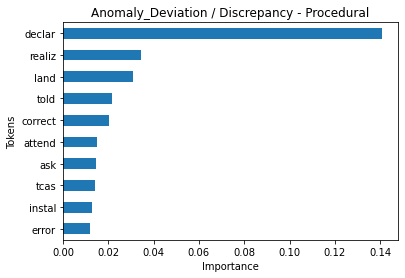

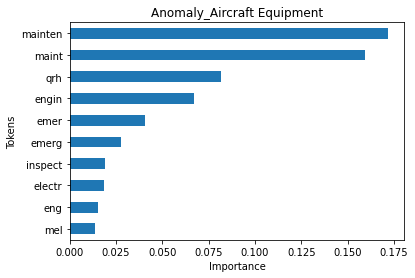

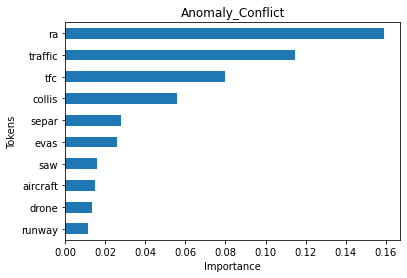

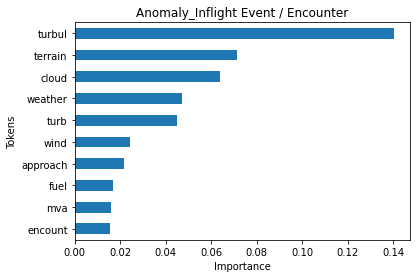

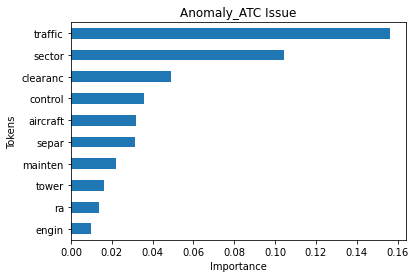

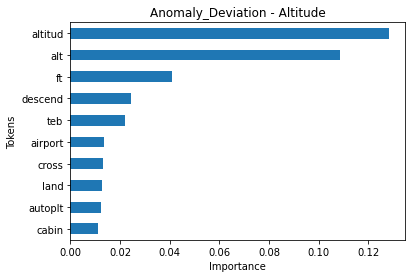

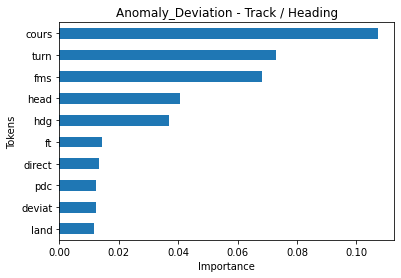

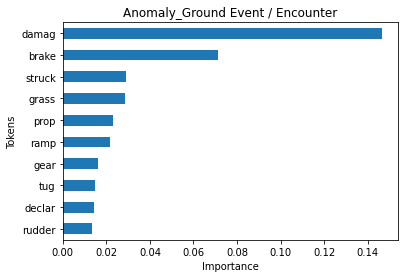

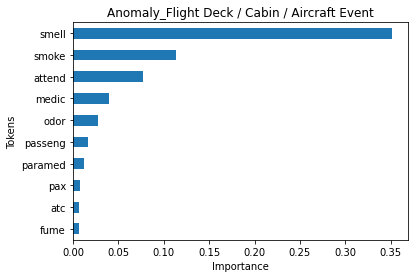

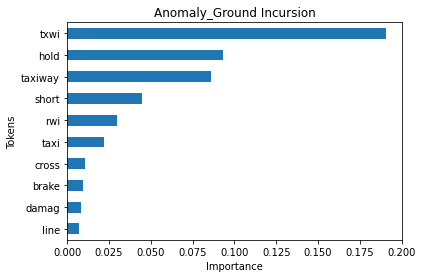

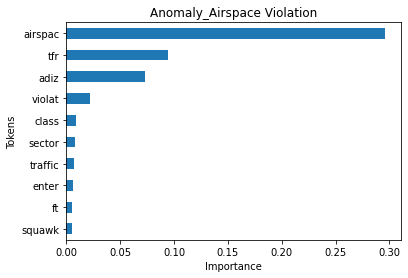

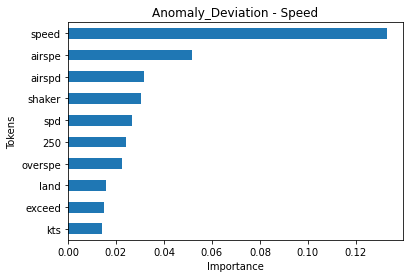

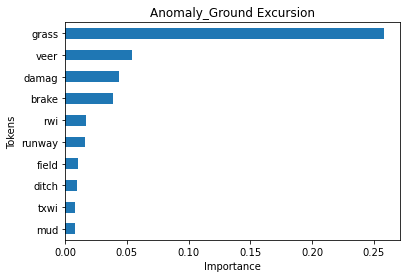

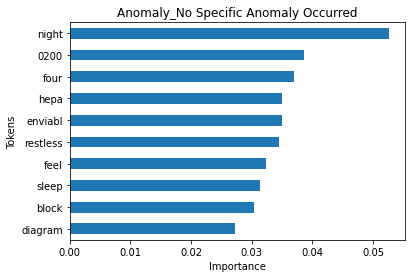

In [17]:
# Plots the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(10)
  topfeatures.set_index('token').plot.barh(  y=[col_importance],legend=None) 
  plt.xlabel('Importance')
  plt.ylabel('Tokens')
  plt.title(Anomaly)

### DT (Gini , Max_Depth=20), PP NARRATIVES,DEFAULT SAMPLING  (df_metrics_DT_PP.pkl)

In [ ]:
# Initializes the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer() 

In [ ]:
# Calls the function 
df_metrics, df_importances = metrics_table_DT(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 50030
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 4.8 minutes ---


In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_PP.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results


#### Token Importance analysis

In [ ]:
len(df_importances)

50030

In [ ]:
df_metrics[df_metrics['metric'] == 'f1-score']

,classifier,preprocessing,undersampling,Count_Vectorizer_opts,anomaly,metric,0,1,accuracy,macro avg,weighted avg
2,Decision Tree,1,0,NaN,Anomaly_Deviation / Discrepancy - Procedural,f1-score,0.546360,0.758999,0.685225,0.652679,0.674077
6,Decision Tree,1,0,NaN,Anomaly_Aircraft Equipment,f1-score,0.866939,0.783363,0.835138,0.825151,0.833910
10,Decision Tree,1,0,NaN,Anomaly_Conflict,f1-score,0.927001,0.634124,0.878286,0.780562,0.874701
14,Decision Tree,1,0,NaN,Anomaly_Inflight Event / Encounter,f1-score,0.921059,0.575887,0.866893,0.748473,0.859936
18,Decision Tree,1,0,NaN,Anomaly_ATC Issue,f1-score,0.921858,0.512227,0.865295,0.717042,0.855022
22,Decision Tree,1,0,NaN,Anomaly_Deviation - Altitude,f1-score,0.954838,0.492269,0.917053,0.723553,0.913536
26,Decision Tree,1,0,NaN,Anomaly_Deviation - Track / Heading,f1-score,0.958315,0.466572,0.922672,0.712443,0.917501
30,Decision Tree,1,0,NaN,Anomaly_Ground Event / Encounter,f1-score,0.962261,0.456962,0.929426,0.709611,0.923604
34,Decision Tree,1,0,NaN,Anomaly_Flight Deck / Cabin / Aircraft Event,f1-score,0.974792,0.662463,0.953088,0.818628,0.950399
38,Decision Tree,1,0,NaN,Anomaly_Ground Incursion,f1-score,0.976481,0.580583,0.955459,0.778532,0.954521


In [ ]:
# Prints the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = False).head(10)
  print(Anomaly,'\n',topfeatures[['token', col_importance]], '\n')

Anomaly_Deviation / Discrepancy - Procedural 
       token      Importance_Anomaly_Deviation / Discrepancy - Procedural
20119     emerg  0.136864                                               
28691      land  0.035267                                               
37717    realiz  0.029509                                               
17851    declar  0.020623                                               
44219      told  0.017749                                               
16546   correct  0.016931                                               
15577  clearanc  0.014878                                               
43355      tcas  0.013411                                               
26263    instal  0.009930                                               
20483     error  0.009580                                                

Anomaly_Aircraft Equipment 
       token     Importance_Anomaly_Aircraft Equipment
30197  mainten  0.316360                             
20119    em

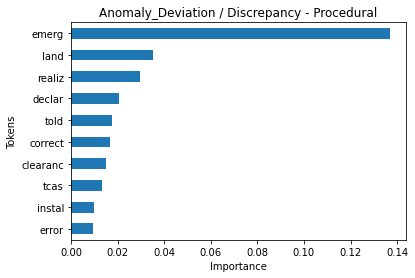

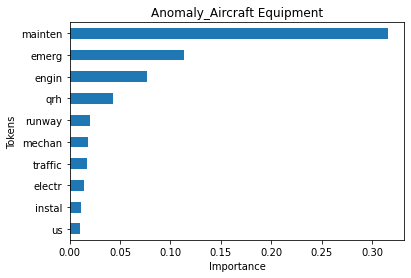

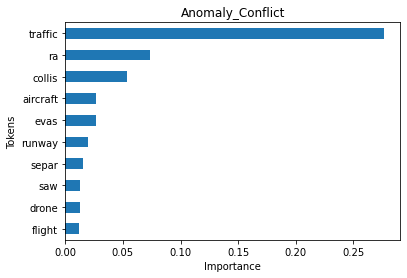

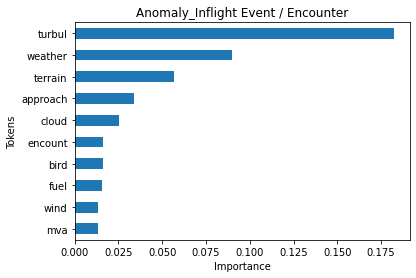

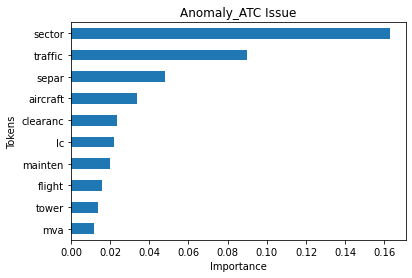

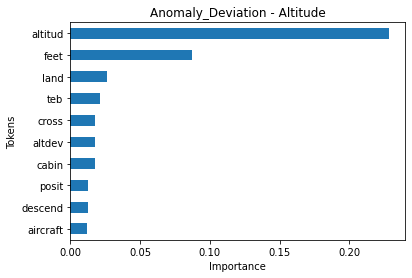

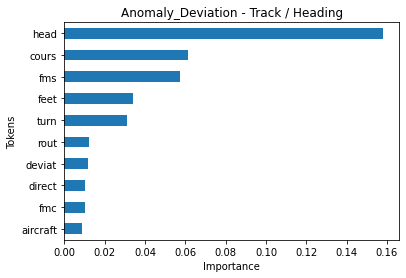

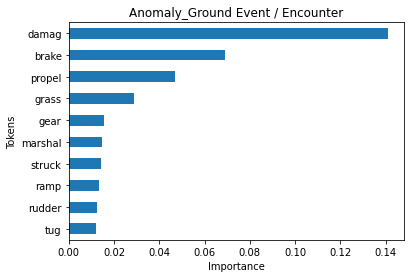

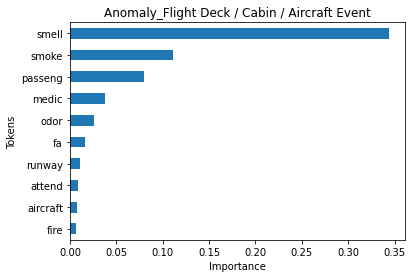

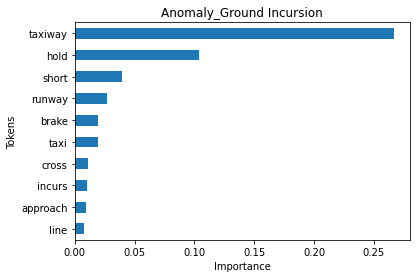

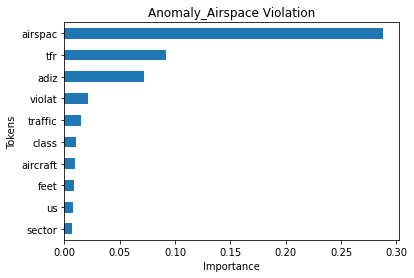

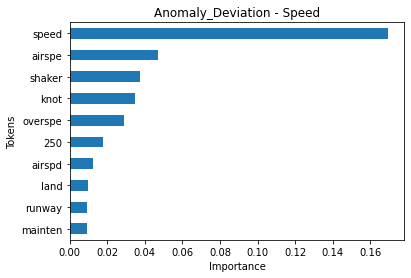

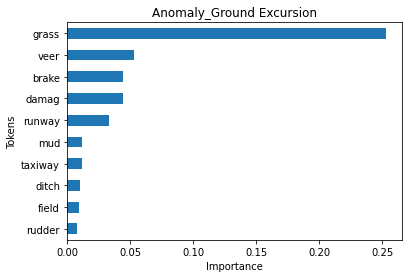

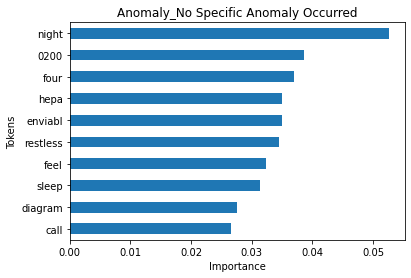

In [ ]:
# Plots the top 10 most important features for each Anomaly label
for Anomaly in target.columns:
  col_importance = 'Importance_' + Anomaly
  topfeatures = df_importances.sort_values(by = col_importance, ascending = True).tail(10)
  topfeatures.set_index('token').plot.barh(  y=[col_importance],legend=None) 
  plt.xlabel('Importance')
  plt.ylabel('Tokens')
  plt.title(Anomaly)


### DT (Gini , Max_Depth=20) x PP NARRATIVES x REMOVE Numbers (df_metrics_DT_PP_RN.pkl)

In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b")

In [ ]:
# Calls the function 
df_metrics, df_importances = metrics_table_DT(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] ='exclude_numerics' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 36543
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion


KeyboardInterrupt: ignored

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_PP_RN.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

### DT (Gini , Max_Depth=20) x PP NARRATIVES x REMOVE Numbers x min_df setting (df_metrics_DT_PP_RN_MDF.pkl)

In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics, df_importances = metrics_table_DT(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] ='exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_PP_RN_MDF.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

## UNDERSAMPLING - Function metrics_table_US (for all classifiers)
-Performs a model with under sampling on the different targets and stock the results

In [ ]:
def metrics_table_US(data, target, vectorizer, classifier):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier  
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # add an extra column ones in the data DataFrame for convenience later during undersampeling
    data = pd.DataFrame(data)
    data['ones'] = 1

    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # Remove from X_test
    X_test = X_test.drop('ones', axis=1)
    X_test = X_test.squeeze()
    
    # Instantiate variables
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]

      # Perform an undersampeling step
      rus = RandomUnderSampler()
      X_ru, y_ru = rus.fit_resample(X_train, y_train_Anomaly)

      # Remove the extra added column of ones from the X_ru and X_test 
      # Remove from X_ru
      X_ru = X_ru.drop('ones', axis=1)
      X_ru = X_ru.squeeze()

      # apply the vectorizer 
      X_ru = vectorizer.fit_transform(X_ru) 
      X_test_Anomaly = vectorizer.transform(X_test) 
      vocab = vectorizer.get_feature_names_out()
      print("Vocabulary length:" , len(vocab))

      # Train & predict
      classifier.fit(X_ru, y_ru)
      y_pred = classifier.predict(X_test_Anomaly)


      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['undersampling'] = 1  # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp

### DT (Gini , Max_Depth=20), RAW NARRATIVES,UNDERSAMPLING  (df_metrics_DT_RAW_US.pkl)

In [ ]:
# Initializes the objects necesseray function inputs
data = df['Narrative_Raw_Stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer() 

In [ ]:
# Calls the function 
df_metrics = metrics_table_US(data, target, vectorizer, clf)


------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 45498
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 45343
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 30576
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 32057
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 30988
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 23259
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 24396
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 20054
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 20064
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 16586
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 17435
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 13446
Prediction

In [ ]:
df_metrics.head()


,metric,0,1,accuracy,macro avg,weighted avg,anomaly,undersampling
0,precision,0.554500,0.758541,0.653819,0.656520,0.676491,Anomaly_Deviation / Discrepancy - Procedural,1
1,recall,0.707722,0.617564,0.653819,0.662643,0.653819,Anomaly_Deviation / Discrepancy - Procedural,1
2,f1-score,0.621811,0.680831,0.653819,0.651321,0.657098,Anomaly_Deviation / Discrepancy - Procedural,1
3,support,7835.000000,11649.000000,0.653819,19484.000000,19484.000000,Anomaly_Deviation / Discrepancy - Procedural,1
4,precision,0.861770,0.771914,0.826730,0.816842,0.827145,Anomaly_Aircraft Equipment,1


In [ ]:

# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 0          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_RAW_US.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results


### DT (Gini , Max_Depth=20), PREPROCESSED NARRATIVES,UNDERSAMPLING  (df_metrics_DT_PP_US.pkl)

In [ ]:
# Initializes the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer() 

In [ ]:
# Calls the function 
df_metrics= metrics_table_US(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 44258
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 43713
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 29810
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 30890
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 30258
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 22887
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 23822
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 19459
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 19641
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 16208
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 16942
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 12885
Prediction

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_PP_US.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results


### DT (Gini , Max_Depth=20), PP NARRATIVES,UNDERSAMPLING  x REMOVE Numbers (df_metrics_DT_PP_US_RN.pkl) 

In [ ]:
# Initializes the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b")

In [ ]:
# Calls the function 
df_metrics= metrics_table_US(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] ='exclude_numerics' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 33005
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 32456
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 23292
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 24396
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 24036
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 18759
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 19532
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 16238
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 16360
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 13245
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 14240
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 11056
Prediction

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_PP_US_RN.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results


### DT (Gini , Max_Depth=20), RAW NARRATIVES,UNDERSAMPLING   x REMOVE Numbers x min_df setting(df_metrics_DT_PP_US_RN_MDF.pkl)

In [ ]:
# Initializes the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = DecisionTreeClassifier(max_depth = 20)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table_US(data, target, vectorizer, clf)

# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Decision Tree'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 8189
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 8137
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 5690
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 5936
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 5582
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 4290
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 4327
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 4140
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 4207
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 3366
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 3303
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 2635
Prediction of anomaly 

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_DT_PP_US_RN_MDF.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results


## RANDOM FOREST

## STANDARD SAMPLING - Function metrics_table (all classifiers)
-Performs a model with standard sampling on the different targets and stock the results  

In [ ]:
def metrics_table(data, target, vectorizer, classifier):
    """
    Return Prediction metrics and feature importance for Decision Trees
    /!\ works only for DT, since the other models don't return Feature importance

    Inputs: 
    - data: pd.Series containing the narratives as single string
    - target: a list of target labels
    - vectorizer instance. Lets you instantiate it with the desired settings
    - classifier (must be a decision tree as we calculate importance)
    
    Return:
    - a DataFrame containing the classification reports for each target label
    - a DataFrame containing the feature importance for each token

    """

    # Time the function execution
    start_time = time.time()
    print(7*'-', "Execution started...", 7*'-', '\n')
    
    # Train-test split  
    X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                        test_size= 0.2, 
                                                        random_state = 12)


    # apply the vectorizer 
    X_train = vectorizer.fit_transform(X_train) 
    X_test = vectorizer.transform(X_test) 
    vocab = vectorizer.get_feature_names_out()
    print("Vocabulary length:" , len(vocab))

    # Instantiate variables
    metrics_df_list = []

    # Loop through Anomaly labels
    for Anomaly in target.columns:

      print('Prediction of anomaly :', Anomaly)

      # Select the correct target data
      y_train_Anomaly = y_train[Anomaly]
      y_test_Anomaly = y_test[Anomaly]
     
      # Train & predict
      classifier.fit(X_train, y_train_Anomaly)
      y_pred = classifier.predict(X_test)

      #########  CLASSIFICATION REPORT #############
      # Classif. report; dict format
      clf_rep = classification_report(y_test_Anomaly, y_pred, output_dict = True)
      # write classification report dictionnary into pd.DataFrame
      metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
      # Fill in with anomaly name
      metrics['anomaly'] = Anomaly
      metrics['undersampling'] = 0              # 1 if undersampling was applied
      metrics_df_list.append(metrics)

    
    metrics_exp = pd.concat(metrics_df_list)
    # Reset index, otherwise you get a repetition of 0,1,2,3
    metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

    
    # Calculate and print time to execute
    end_time = time.time()
    print(f"--- DONE! It took {np.round((end_time - start_time)/60,1)} minutes ---")

    return metrics_exp 

### RF, PP NARRATIVES,DEFAULT SAMPLING x  x REMOVE Numbers x min_df setting (df_metrics_RF_PP_RN_MDF.pkl)

In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
#target = df[['Anomaly_Aircraft Equipment']]
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table(data, target, vectorizer, clf)
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Random Forest'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

------- Execution started... ------- 

Vocabulary length: 9130
Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Prediction of anomaly : Anomaly_Aircraft Equipment
Prediction of anomaly : Anomaly_Conflict
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Prediction of anomaly : Anomaly_ATC Issue
Prediction of anomaly : Anomaly_Deviation - Altitude
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Prediction of anomaly : Anomaly_Ground Event / Encounter
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Prediction of anomaly : Anomaly_Ground Incursion
Prediction of anomaly : Anomaly_Airspace Violation
Prediction of anomaly : Anomaly_Deviation - Speed
Prediction of anomaly : Anomaly_Ground Excursion
Prediction of anomaly : Anomaly_No Specific Anomaly Occurred
--- DONE! It took 23.5 minutes ---


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_RF_PP_RN_MDF.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results


### RF, PP NARRATIVES,UNDER SAMPLING   x REMOVE Numbers x min_df setting  (df_metrics_RF_PP_US_RN_MDF.pkl)

In [ ]:
# initialize the objects necesseray function inputs
data = df['Narrative_PP_stemmed_str']
target = df[Anomaly_RootLabels_columns]
clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
vectorizer = CountVectorizer(token_pattern=r"\b[a-zA-Z][a-zA-Z]+\b",
                             min_df = 12)

In [ ]:
# Calls the function 
df_metrics = metrics_table_US(data, target, vectorizer, clf)


------- Execution started... ------- 

Prediction of anomaly : Anomaly_Deviation / Discrepancy - Procedural
Vocabulary length: 8225
Prediction of anomaly : Anomaly_Aircraft Equipment
Vocabulary length: 8144
Prediction of anomaly : Anomaly_Conflict
Vocabulary length: 5745
Prediction of anomaly : Anomaly_Inflight Event / Encounter
Vocabulary length: 5914
Prediction of anomaly : Anomaly_ATC Issue
Vocabulary length: 5620
Prediction of anomaly : Anomaly_Deviation - Altitude
Vocabulary length: 4299
Prediction of anomaly : Anomaly_Deviation - Track / Heading
Vocabulary length: 4361
Prediction of anomaly : Anomaly_Ground Event / Encounter
Vocabulary length: 4172
Prediction of anomaly : Anomaly_Flight Deck / Cabin / Aircraft Event
Vocabulary length: 4212
Prediction of anomaly : Anomaly_Ground Incursion
Vocabulary length: 3380
Prediction of anomaly : Anomaly_Airspace Violation
Vocabulary length: 3313
Prediction of anomaly : Anomaly_Deviation - Speed
Vocabulary length: 2630
Prediction of anomaly 

In [ ]:
df_metrics.head()

,metric,0,1,accuracy,macro avg,weighted avg,anomaly,undersampling
0,precision,0.684724,0.803065,0.753285,0.743895,0.755477,Anomaly_Deviation / Discrepancy - Procedural,1
1,recall,0.716273,0.778178,0.753285,0.747226,0.753285,Anomaly_Deviation / Discrepancy - Procedural,1
2,f1-score,0.700143,0.790426,0.753285,0.745285,0.754121,Anomaly_Deviation / Discrepancy - Procedural,1
3,support,7835.000000,11649.000000,0.753285,19484.000000,19484.000000,Anomaly_Deviation / Discrepancy - Procedural,1
4,precision,0.917970,0.822969,0.879080,0.870470,0.881362,Anomaly_Aircraft Equipment,1


In [ ]:
# Fill in additionnal columns with metadata
df_metrics['classifier'] = 'Random Forest'  # [dt, rf, Word_Embedding, ...]
df_metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
df_metrics['Count_Vectorizer_opts'] = 'exclude_numerics;min_df = 12' # ['exclude_numerics'; 'min_df = 12'; ...]
# Reorder columns
df_metrics = df_metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]

In [ ]:
print(df_metrics.shape, " should be (56 , 11)")

(56, 11)  should be (56 , 11)


In [ ]:
# # Saves the metrics into a pkl file
# import pickle
# %cd /content/drive/MyDrive/data/transformed/model_results/
# filename = 'df_metrics_RF_PP_US_RN_MDF.pkl'
# #enregistre le modèle
# pickle.dump([df_metrics], open(filename, 'wb'))

/content/drive/MyDrive/data/transformed/model_results


## WordEmbedding 1vs.All - First attempt

In [ ]:
def word_embedding_clf(data, target, maxlen, num_words, N_emb): 
  """
  Perform binary classification using WordEmbedding

  Inputs:
  - data as pd.Series, narrative strings, e.g. df['Narrative_PP_stemmed_str']
  - target as pd.Series, e.g. df['Anomaly_Conflict']
  - maxlen (int) : length of the text vector (in words). Will ignore narrative content beyond this limit
  - num_words (int): desired vocab size; only the most common words are kept
  - N_emb (int) = 200: Dimension of embedding (# columns of the embedding matrix)
    # reducing this from 200 to 100 improved the f1-score of '1' from 0.85 to 0.87 !
    # reducing to 50 did not improve the f1 further


  Returns:
  - training history
  - 'metrics': pd.Dataframe containing the classification report content
  """ 

  # Time the function execution
  start_time = time.time()
  anomaly_name = target.name
  print(7*'-', f"Execution started for label '{anomaly_name}' ...", 7*'-')

  # One-hot encode target
  target = to_categorical(target) 
  # Train-test split  
  X_text_train, X_text_test, y_train, y_test = train_test_split(data, target, 
                                                      test_size= 0.2,
                                                      random_state = 12) 

  ###############################
  # TOKENIZE
  from tensorflow.keras.preprocessing.text import Tokenizer

  tokenizer = Tokenizer(num_words = num_words, # only the most common words are kept
                        oov_token = 'OOV'
                        ) 
  tokenizer.fit_on_texts(X_text_train) # Updates internal vocabulary based on a list of texts

  # Save the dictionary of correspondence between words and indices
  word2idx = tokenizer.word_index
  # Save the dictionary of correspondence between indices and words
  idx2word = tokenizer.index_word
  # Save the vocab size
  vocab_size = tokenizer.num_words  
  print('Tokenization completed.')
  print(f'Vocabulary size: {vocab_size} (user-defined)\n')
  example_OOV = word2idx['OOV']
  print(f"Example: index of 'OOV': {example_OOV} (Out-Of-Vocabulary label; user-defined)")
  example_aircraft = word2idx['aircraft']
  print(f"Example: index of 'aircraft': {example_aircraft}\n")
  print(30*"-")

  ###############################
  # VECTORIZE NARRATIVES
  # Map each text into a sequence of integers (word indices)
  # We use the vocab obtained from training on the X_text_train data to vectorize both the train and test data
  # Transform every review into a sequence of integers (indices of the vocab)
  X_train = tokenizer.texts_to_sequences(X_text_train)
  X_test = tokenizer.texts_to_sequences(X_text_test)
  print('Vectorization completed.')
  rnd_idx = np.random.randint(len(X_train), size = 2)
  for idx in rnd_idx:
    print(f'Random examples of entries in X_train:\n {X_train[idx]}')
    print(f'Length: {len(X_train[idx])}\n')
  print(30*"-")

  # Pad & truncate train and test sequences (texts transformed in numeric sequences) to make them of the same length
  X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, # Liste des textes transformés en index
                                                          maxlen = maxlen, # Nombre maximal de mots dans un texte. See length analysis above
                                                          padding = 'post', # pad either before or after each sequence
                                                          truncating = 'post', # truncate either before or after each sequence
                                                          value=0.0) # with what to pad
  # if maxlen is not provided, uses the length of the longest sequence in the list.
  X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen = maxlen, padding = 'post', truncating= 'post')
  print('Sequence padding / truncating completed.\n')
  print(f'Each entry in X_train has length: {maxlen} (user-defined)\n')
  
  for idx in rnd_idx:
    print(f"Entries in X_train now look like this (observe the presence of '1', corresponding to 'OOV'):\n\n {X_train[idx]}\n")
  print(30*"-")  

  ###############################
  # BUILD THE MODEL
  tf.keras.backend.clear_session()
  # Keras starts with a blank state at each iteration and memory consumption is constant over time.
  
  model = Sequential(name = "Word_Embedding_model") # does not accept spaces
  model.add(Embedding(input_dim = vocab_size, output_dim = N_emb)) # The embedding matrix is a *trainable* parameter
  model.add(GlobalAveragePooling1D()) # no parameters to tune; it's an advantage of GlobalAveragePooling1D
  # Use global average pooling blocks as an alternative to a Flatten() layer 

  model.add(Dense(units = 32, activation = 'relu'))
  model.add(Dropout(rate = 0.3)) # prevents overfitting
  model.add(Dense(units = 2, activation = 'sigmoid')) # 2 units, because BINARY classification problem
  # 'sigmoid' activation because binary classification
  print(model.summary())

  ###############################   
  # Define CALLBACKS
  TON = callbacks.TerminateOnNaN() # Callback that terminates training when a NaN loss is encountered

  early_stopping = callbacks.EarlyStopping(monitor = 'binary_accuracy', # 'binary_accuracy' calculates how often predictions match binary labels.
                                          min_delta=0.01,
                                          patience = 7, 
                                          mode = 'max', 
                                          restore_best_weights = True, 
                                          verbose = 1)

  lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'binary_accuracy',
                                          patience = 3, 
                                          verbose = 1, # nombre d'informations qui seront affichées durant l'apprentissage
                                          min_delta=0.01,
                                          mode = 'max')
  ###############################
  # Compile and FIT the model
  opt = keras.optimizers.Adam(#learning_rate = 0.0001 # default learning_rate = 0.001
                              ) 
  model.compile(optimizer = opt, 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', 'binary_accuracy', 'binary_crossentropy']) # see https://keras.io/api/metrics/

  training_history = model.fit(
            X_train, y_train,
            validation_split = 0.2,
            epochs = 50, # very high number; callbacks will stop it earlier anyway
            batch_size = 32, # the higher, the faster one epoch is completed
            callbacks = [TON, early_stopping, lr_plateau
                         ],
            verbose = True)
  
  ###############################
  # Plot the train history
  plot_train_history(training_history, 'accuracy', anomaly_name)
  plot_train_history(training_history, 'loss', anomaly_name)

  ###############################
  # EVALUATE
  y_pred = model.predict(X_test, batch_size=32, verbose=1)
  y_pred_bool = np.argmax(y_pred, axis=1)
  y_test_bool = np.argmax(y_test, axis=1)

  print(f"\n\n Classification Report for label '{anomaly_name}': \n {classification_report(y_test_bool, y_pred_bool)}\n")

  ###############################
  # EXPORT CLASSIFICATION REPORT

  # Classif. report; dict format
  clf_rep = classification_report(y_test_bool, y_pred_bool, output_dict = True)
  # write classification report dictionnary into pd.DataFrame
  metrics = pd.DataFrame(clf_rep).reset_index().rename(columns = {'index': 'metric'})
  # Fill in with anomaly name
  metrics['anomaly'] = anomaly_name
  # Fill in additionnal columns with metadata
  metrics['classifier'] = 'Word_Embedding'  # [dt, rf, Word_Embedding, ...]
  metrics['preprocessing'] = 1          # 0 if raw, 1 if preprocessed
  metrics['undersampling'] = 0              # 1 if undersampling was applied
  metrics['Count_Vectorizer_opts'] = np.nan # ['exclude_numerics'; 'min_df = 12'; ...]
  # Reorder columns
  metrics = metrics[['classifier', 'preprocessing', 'undersampling', 'Count_Vectorizer_opts',
                     'anomaly', 'metric', '0', '1', 'accuracy', 'macro avg', 'weighted avg']]
  
  # Calculate and print time to execute
  print(7*'-', f"Execution finished for label '{anomaly_name}' !", 7*'-')
  end_time = time.time()
  print(f"--- It took {np.round((end_time - start_time)/60,1)} minutes --- \n\n")

  return training_history, metrics

### Test on 1 Anomaly label

In [ ]:
# Test: Call the function on ONE anomaly label
training_history, metrics = word_embedding_clf(df['Narrative_PP_stemmed_str'], 
                                               df['Anomaly_Conflict'],
                                              ( maxlen = 200, 
                                               num_words = 3000, 
                                               N_emb = 200))

### Loop through all anomalies

In [ ]:
# /!\ takes time to run!
# Call the function looping on ALL anomalies
# list of metrics DataFrames of our experiment
metrics_df_list = []

for anomaly in Anomaly_RootLabels_columns:
  training_history, metrics = word_embedding_clf(df['Narrative_PP_stemmed_str'], df[anomaly])
  metrics_df_list.append(metrics)

metrics_exp = pd.concat(metrics_df_list)
# Reset index, otherwise you get a repetition of 0,1,2,3
metrics_exp = metrics_exp.reset_index().drop(columns =['index'])

In [ ]:
# # save the df externally
# ##########################################################
# # WARNING!! 
# # If you execute this cell, you will OVERWRITTE the data!
# ##########################################################

# %cd /content/drive/MyDrive/data/transformed/model_results/

# with open("metrics_WordEmbedding_20220727_2200.pkl", "wb") as f:
#     pkl.dump([metrics_exp], f) # saves the variables into a list